# BBM 409 - Programming Assignment 4

####  Erdinç Arıcı - 2210356035

## Understanding LSTM's with Sentiment Analysis (100 points)

### 1. Data Loading and Exploration (5 points)

Brief Overview of the Task
The goal of this task is to build and evaluate a LSTM model for sentiment analysis using a subset of the IMDB dataset. Sentiment analysis involves classifying text data into categories, such as positive or negative sentiments. The primary focus of task is on understanding how LSTM networks handle sequential data, such as text, and leveraging pre-trained word embeddings for efficient feature representation.

Description of the dataset is detailed in the third cell.

In [1]:
import re
import nltk
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from collections import Counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from google.colab import drive, files
from sklearn.decomposition import PCA
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from mpl_toolkits.mplot3d import Axes3D
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/subset10000_IMDB_Dataset.csv')
df['labels'] = df['sentiment'].map({'positive': 1, 'negative': 0})

Mounted at /content/drive


In [3]:
print("Basic Information about the Dataset")
print(df.info())

print("\nDataset Size and Features")
print(f"Number of rows: {df.shape[0]}, Number of columns: {df.shape[1]}")

print("\nColumn Names")
print(df.columns.tolist())

print("\nSummary Statistics for Numerical Columns")
print(df.describe())

print("\nChecking for Missing Values")
print(df.isnull().sum())

print("\nDistribution of Sentiment Labels")
print(df['sentiment'].value_counts())

print("\nFirst Few Rows of the Dataset")
df.head()

Basic Information about the Dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     10000 non-null  object
 1   sentiment  10000 non-null  object
 2   labels     10000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 234.5+ KB
None

Dataset Size and Features
Number of rows: 10000, Number of columns: 3

Column Names
['review', 'sentiment', 'labels']

Summary Statistics for Numerical Columns
             labels
count  10000.000000
mean       0.500000
std        0.500025
min        0.000000
25%        0.000000
50%        0.500000
75%        1.000000
max        1.000000

Checking for Missing Values
review       0
sentiment    0
labels       0
dtype: int64

Distribution of Sentiment Labels
sentiment
negative    5000
positive    5000
Name: count, dtype: int64

First Few Rows of the Dataset


,review,sentiment,labels
0,"Starts really well, nice intro and build up fo...",negative,0
1,"Terrific movie: If you did not watch yet, you ...",positive,1
2,I've seen hundreds of silent movies. Some will...,positive,1
3,i had been looking for this film for so long b...,positive,1
4,"Good: Engaging cinematic firefights, great pre...",positive,1


### 2. Preprocessing the Data (10 points)

In [4]:
def pad_sequence(seq, max_len):
    if len(seq) < max_len:
        return seq + [0] * (max_len - len(seq))
    else:
        return seq[:max_len]

In [5]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    text = re.sub(r'[\/]', ' ', text)
    text = re.sub(r'<.*?>', ' ', text)
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [6]:
df['tokens'] = df['review'].apply(preprocess_text)

counter = Counter()
df['tokens'].apply(counter.update)
tokens_code = {word: idx + 1 for idx, (word, _) in enumerate(counter.most_common())}
tokens_code['<PAD>'] = 0

df['length'] = df['tokens'].apply(len)
print("Statistical details about review lengths:\n", df['length'].describe())

max_lenght = int(df['length'].quantile(0.85))
print(f"\nPadding length: {max_lenght}")

df['indices'] = df['tokens'].apply(lambda tokens: [tokens_code.get(token, 0) for token in tokens])
df['padded_indices'] = df['indices'].apply(lambda indices: pad_sequence(indices, max_lenght))

Statistical details about review lengths:
 count    10000.000000
mean       117.773300
std         89.214813
min          4.000000
25%         63.000000
50%         88.000000
75%        145.000000
max        809.000000
Name: length, dtype: float64

Padding length: 191


By using the 85th percentile of review lengths, we ensure that most of the reviews are fully preserved without truncation, while only the longest 15% are shortened. This decision prevents excessive padding, which would waste memory and computational resources, especially for shorter reviews. It also ensures the model remains efficient during training while maintaining the necessary context for accurate predictions. This approach helps balance performance and resource constraints effectively.

### 3. Visualzing Word Vectors (15 points)

In [7]:
import gensim.downloader as api
fasttext_vectors = api.load("fasttext-wiki-news-subwords-300")
print("FastText model loaded.")

[==================================================] 100.0% 958.5/958.4MB downloaded
FastText model loaded.


In [8]:
oov = [word for word in tokens_code.keys() if word not in fasttext_vectors.key_to_index]

print(f"Total Vocabulary Size: {len(tokens_code)}")
print(f"Number of OOV Words: {len(oov)}")
print(f"OOV Percentage: {100 * len(oov) / len(tokens_code):.2f}%")

Total Vocabulary Size: 45753
Number of OOV Words: 10943
OOV Percentage: 23.92%


In my dataset, 24% of the words are OOV, meaning they are not present in the pre-trained word vectors. This limits the model's ability to learn semantic relationships between words and negatively impacts performance. If important words are OOV, tasks like sentiment analysis may suffer in accuracy. To mitigate this, I could consider using a more suitable word embedding or preprocess the OOV words more effectively.

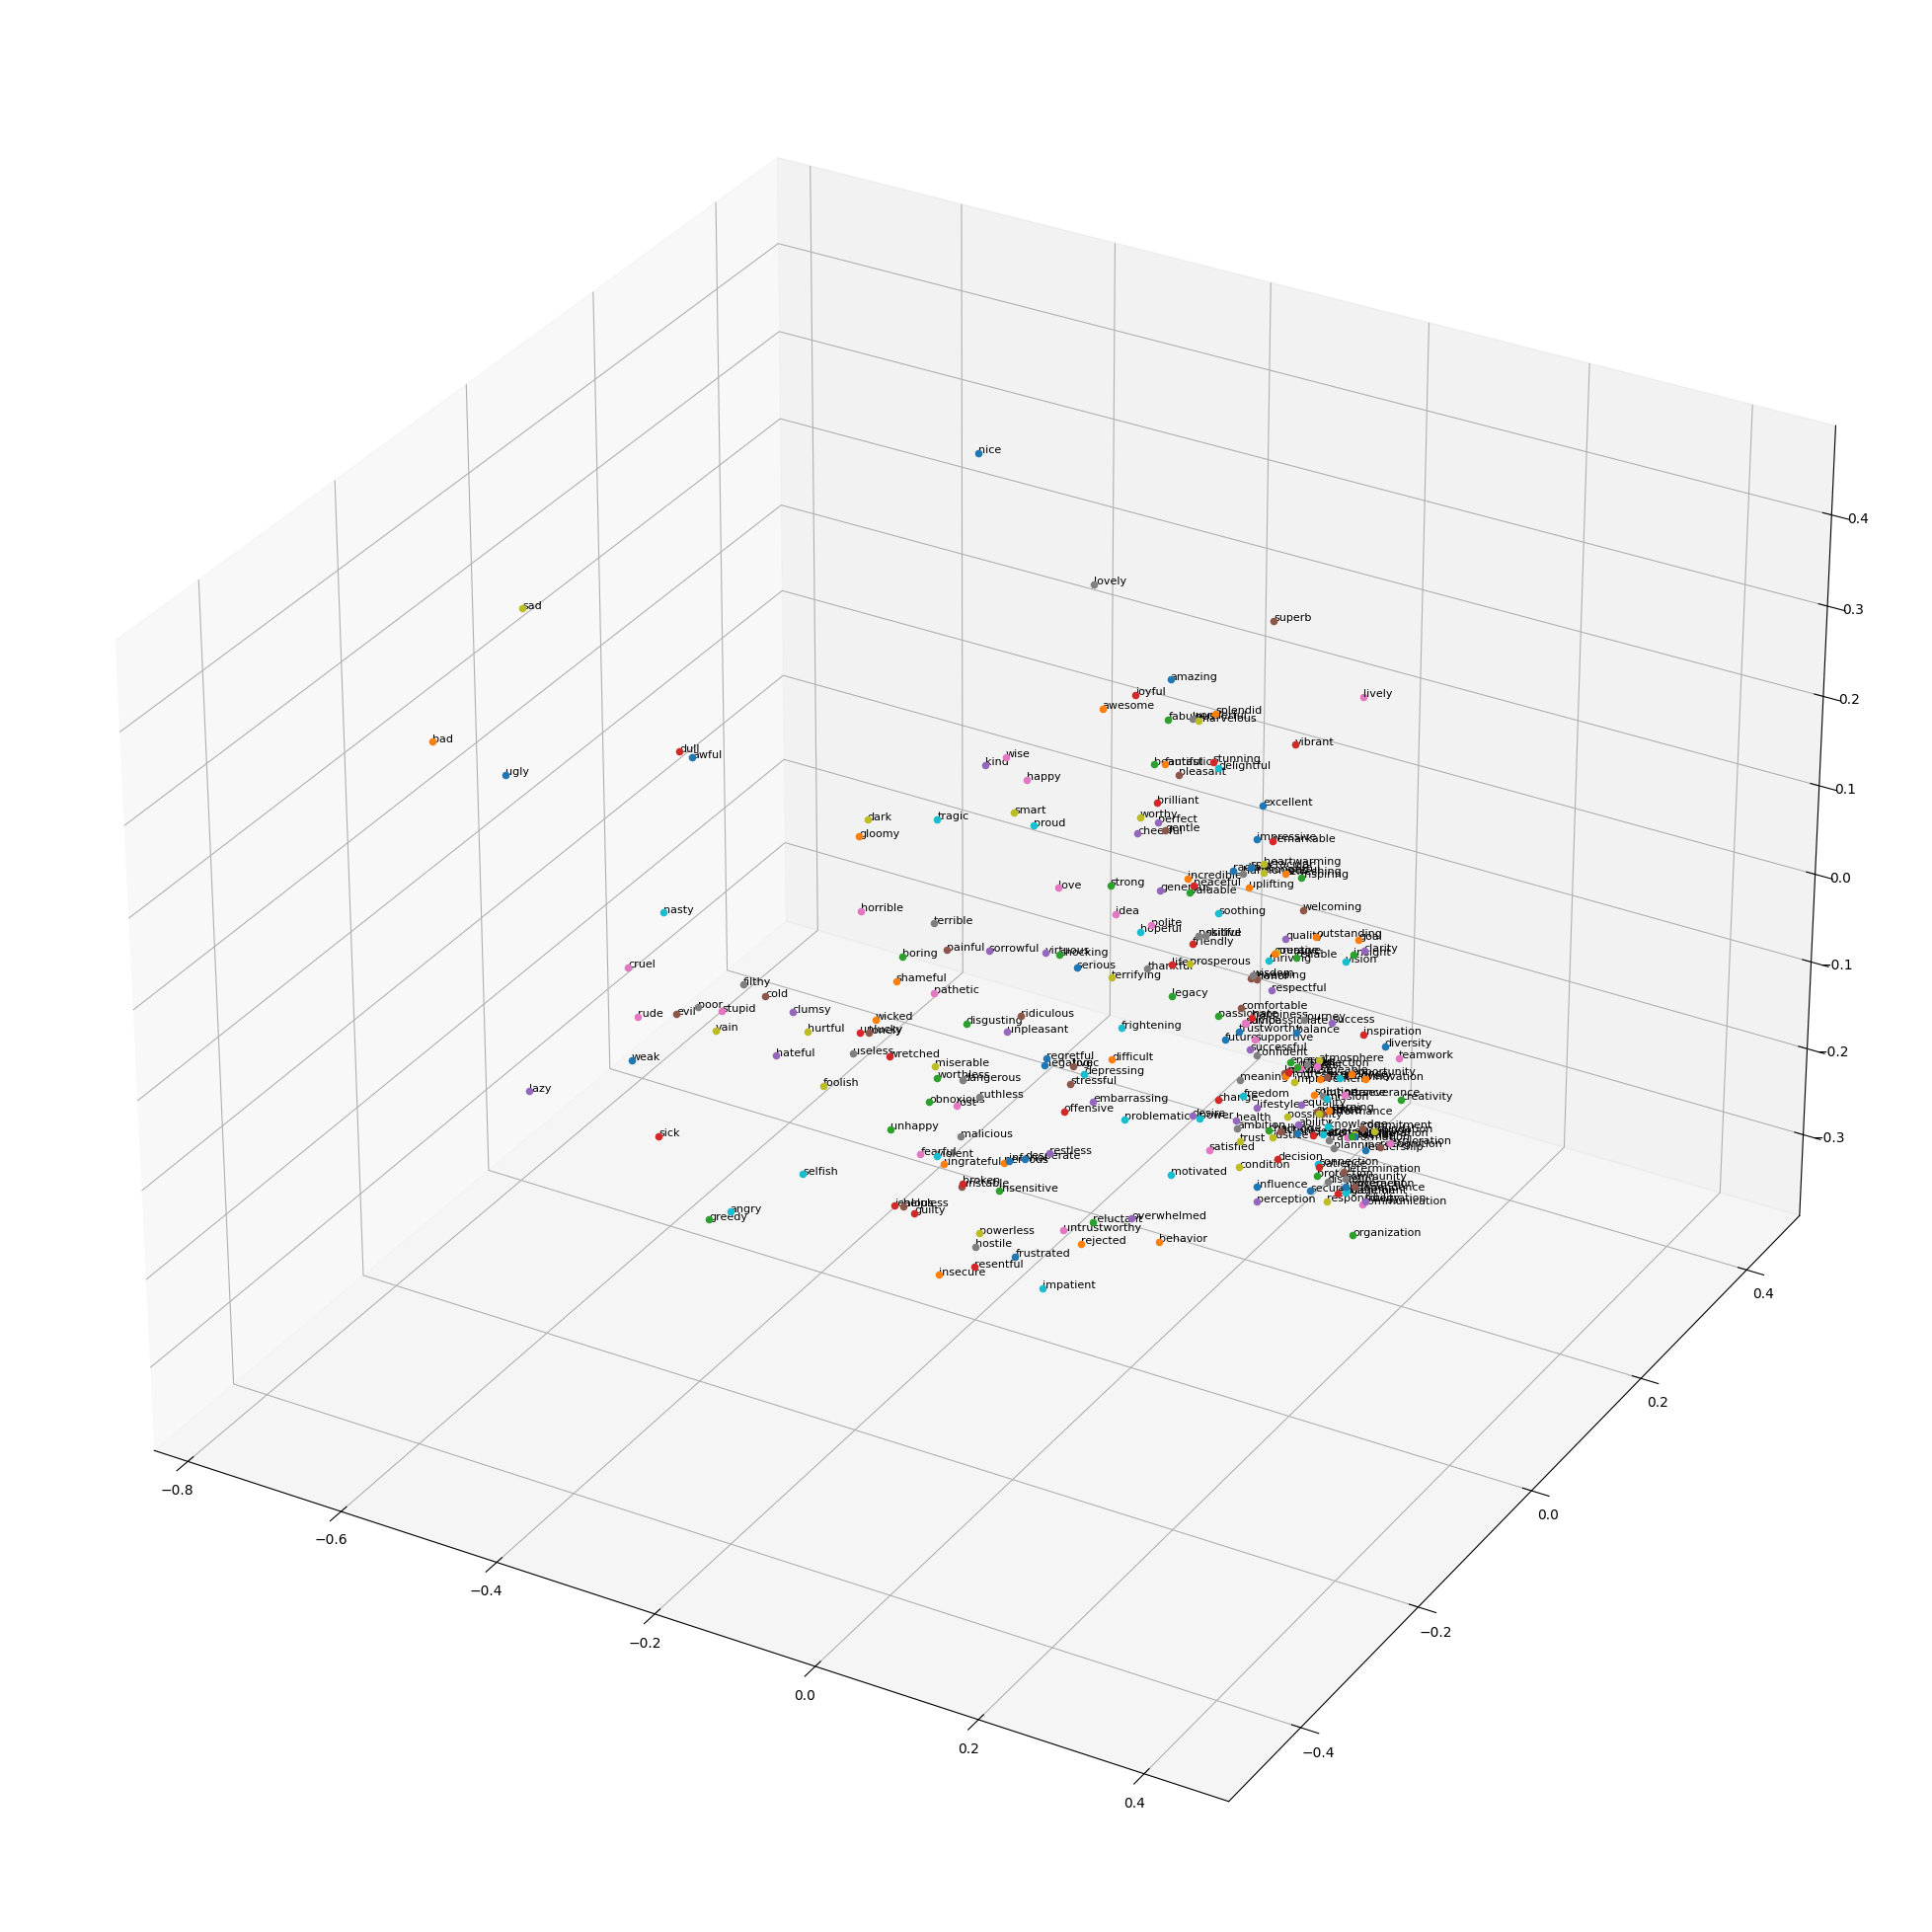

In [9]:
sentiment_rich = ["amazing", "awesome", "beautiful", "brilliant", "cheerful", "comfortable", "compassionate", "confident", "creative", "delightful", "excellent", "fantastic", "fabulous", "friendly", "generous", "gentle", "happy", "harmonious", "heartwarming", "hopeful", "impressive", "incredible", "inspiring", "joyful", "kind", "knowledgeable", "lively", "lovely", "marvelous", "motivated", "nice", "outstanding", "passionate", "peaceful", "perfect", "pleasant", "polite", "positive", "prosperous", "proud", "radiant", "refreshing", "reliable", "remarkable", "respectful", "rewarding", "satisfied", "skillful", "smart", "soothing", "spectacular", "splendid", "strong", "stunning", "successful", "superb", "supportive", "thankful", "thoughtful", "thriving", "trustworthy", "uplifting", "valuable", "vibrant", "virtuous", "welcoming", "wise", "wonderful", "worthy", "angry", "awful", "bad", "boring", "broken", "clumsy", "cold", "cruel", "dangerous", "dark", "depressing", "desperate", "difficult", "disgusting", "dull", "embarrassing", "evil", "fearful", "filthy", "foolish", "frightening", "frustrated", "gloomy", "greedy", "guilty", "hateful", "helpless", "horrible", "hostile", "hurtful", "impatient", "inferior", "insecure", "insensitive", "jealous", "lazy", "lonely", "lost", "malicious", "miserable", "nasty", "negative", "nervous", "obnoxious", "offensive", "overwhelmed", "painful", "pathetic", "poor", "powerless", "problematic", "regretful", "rejected", "reluctant","resentful", "restless", "ridiculous", "rude", "ruthless", "sad", "selfish", "serious", "shameful", "shocking", "sick", "sorrowful", "stressful", "stupid", "terrible", "terrifying", "tragic", "ugly", "ungrateful", "unhappy", "unlucky", "unpleasant", "unstable", "untrustworthy", "useless", "vain", "violent", "weak", "wicked", "worthless", "wretched", "ability", "action", "advice", "ambition", "atmosphere", "attention", "balance", "behavior", "challenge", "change", "clarity", "commitment", "communication", "community", "condition", "connection", "consideration", "courage", "creativity", "decision", "desire", "determination", "direction", "discipline", "discussion", "discovery", "diversity", "effort", "energy", "engagement", "equality", "experience", "exploration", "focus", "foundation", "freedom", "future", "goal", "growth", "happiness", "health", "honor", "idea", "importance", "improvement", "independence", "influence", "innovation", "insight", "inspiration", "integration", "interaction", "interest", "journey", "justice", "knowledge", "leadership", "learning", "legacy", "life", "lifestyle", "logic", "love", "meaning", "method", "mission", "movement", "opportunity", "organization", "patience", "perception", "performance", "perseverance", "planning", "possibility", "power", "presence", "progress", "protection", "purpose", "quality", "recognition", "reflection", "wisdom", "responsibility", "satisfaction", "security", "solution", "stability", "strategy", "success", "support", "teamwork", "transformation", "trust", "vision"]
sentiment_rich_in_vocab = [word for word in sentiment_rich if word in tokens_code]
vectors = [fasttext_vectors[word] for word in sentiment_rich if word in fasttext_vectors]

pca_3d = PCA(n_components = 3)
vectors_3d = pca_3d.fit_transform(vectors)

figure = plt.figure(figsize=(25, 50))
ax = figure.add_subplot(111, projection = '3d')
for i, word in enumerate(sentiment_rich_in_vocab):
    ax.scatter(vectors_3d[i, 0], vectors_3d[i, 1], vectors_3d[i, 2])
    ax.text(vectors_3d[i, 0], vectors_3d[i, 1], vectors_3d[i, 2], word, fontsize=8)
plt.show()

The 3D visualization effectively shows clustering of semantically similar words. Positive sentiment words like "amazing," "awesome," and "joyful" are grouped closely together, while negative sentiment words such as "terrible," "awful," and "sad" form their own clusters. Opposite terms, such as "happy" and "sad," are positioned far apart, reflecting their contrasting meanings. This spatial distribution highlights how word embeddings capture semantic relationships, with distances reflecting similarity and directionality encoding opposites or related concepts.

### 4. Creating the Embedding Matrix (10 points)

In [10]:
def create_embedding_matrix(word2vec, tokens_code, embedding_dim):
    embedding_matrix = np.zeros((len(tokens_code), embedding_dim))

    for word, i in tokens_code.items():
        if word in word2vec:
            embedding_matrix[i - 1] = word2vec[word]
    return embedding_matrix

embedding_matrix = create_embedding_matrix(fasttext_vectors, tokens_code, 300)
embedding_tensor = torch.tensor(embedding_matrix, dtype=torch.float)
embedding_layer = nn.Embedding.from_pretrained(embedding_tensor, freeze=False)

### 5. Implementing the IMDBDataset (5 points)

In [11]:
class Dataset(Dataset):
    def __init__(self, padded_indices, labels):
        self.padded_indices = padded_indices
        self.labels = labels

    def __len__(self):
        return len(self.padded_indices)

    def __getitem__(self, idx):
        return (torch.tensor(self.padded_indices[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.float))

dataset = Dataset(df["padded_indices"].tolist(), df["labels"].tolist())

train_lenght = int(0.7 * len(dataset))
val_lenght = int(0.2 * len(dataset))
test_lenght = len(dataset) - train_lenght - val_lenght
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_lenght, val_lenght, test_lenght])

train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True, num_workers=12, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size = 64, shuffle = False, num_workers=12, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False, num_workers=12, pin_memory=True)

### 6. Implementing and Optimizing the Custom LSTM model (40 points)

In [12]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMCell, self).__init__()

        self.linear = nn.Linear(input_size + hidden_size, 4 * hidden_size)

    def forward(self, x_t, h_prev, c_prev):
        combined = torch.cat((x_t, h_prev), dim=1)
        gates = self.linear(combined)
        f_g, i_g, c_g, o_g = gates.chunk(4, dim=1)

        f_g = torch.sigmoid(f_g)
        i_g = torch.sigmoid(i_g)
        c_g = torch.tanh(c_g)
        o_g = torch.sigmoid(o_g)

        c_t = f_g * c_prev + i_g * c_g
        h_t = o_g * torch.tanh(c_t)

        return h_t, c_t

In [13]:
class LSTMLayer(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMLayer, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.cell = LSTMCell(input_size, hidden_size)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()

        h_t, c_t = torch.zeros(batch_size, self.hidden_size, device=x.device), torch.zeros(batch_size, self.hidden_size, device=x.device)
        outputs = []

        for t in range(seq_len):
            x_t = x[:, t, :]
            h_t, c_t = self.cell(x_t, h_t, c_t)

            outputs.append(h_t.unsqueeze(1))

        outputs = torch.cat(outputs, dim=1)

        return outputs, (h_t, c_t)

In [14]:
class SentimentLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, embedding_layer):
        super(SentimentLSTM, self).__init__()

        self.embedding = embedding_layer
        self.lstm = LSTMLayer(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)

        final_hidden_state = lstm_out[:, -1, :]

        output = self.fc(final_hidden_state)
        output = self.sigmoid(output)
        output = output.squeeze(1)

        return output

In [15]:
input_size = 300
hidden_size = 128
output_size = 1
epochs = 50
learning_rate = 0.001

In [16]:
model = SentimentLSTM(input_size, hidden_size, output_size, embedding_layer)
model = model.to(device)

In [17]:
loss_func = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

I chose nn.BCEWithLogitsLoss because the task involves binary classification. This loss function is specifically designed for binary classification tasks as it combines a sigmoid layer and binary cross-entropy loss into a single function. By directly using logits, it avoids numerical instability and improves performance.

The Adam optimizer is selected because it is computationally efficient, requires less tuning of hyperparameters, and adapts the learning rate for each parameter dynamically. Its ability to handle sparse gradients and perform well in noisy datasets makes it a great choice for NLP tasks like sentiment analysis. Additionally, the specified learning rate ensures gradual and stable convergence.

In [18]:
best_acc = 0.0
train_losses, val_losses, val_accs = [], [], []

print(f"Epoch\t|\tTrain Loss\tVal Loss\tAcc")
for epoch in range(epochs):
    train_loss, val_loss = 0.0, 0.0
    y_trues, y_preds = [], []

    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            val_loss += loss.item()

            predicted = (outputs > 0.5).long()
            y_trues.extend(labels.cpu().numpy())
            y_preds.extend(predicted.cpu().numpy())

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    epoch_acc = accuracy_score(y_trues, y_preds)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accs.append(epoch_acc)

    if epoch_acc > best_acc:
        best_acc = epoch_acc
        torch.save(model.state_dict(), f"best_model.pth")

    print(f"{epoch + 1}\t|\t{train_loss:.4f}\t\t{val_loss:.4f}\t\t{epoch_acc * 100:.2f}%")

model.load_state_dict(torch.load(f"best_model.pth", weights_only = True))


Epoch	|	Train Loss	Val Loss	Acc
1	|	0.6952		0.6932		52.45%
2	|	0.6931		0.6934		52.45%
3	|	0.6842		0.6894		54.20%
4	|	0.6712		0.6906		54.55%
5	|	0.6641		0.6905		54.85%
6	|	0.6633		0.6897		54.70%
7	|	0.6627		0.6890		55.30%
8	|	0.6623		0.6875		55.25%
9	|	0.6627		0.6918		54.70%
10	|	0.6624		0.6878		55.25%
11	|	0.6617		0.6880		54.80%
12	|	0.6617		0.6876		55.05%
13	|	0.6612		0.6887		55.35%
14	|	0.6622		0.6943		54.25%
15	|	0.6609		0.6862		55.70%
16	|	0.6462		0.6486		68.10%
17	|	0.6086		0.6727		70.15%
18	|	0.5848		0.6530		63.65%
19	|	0.5746		0.6254		75.20%
20	|	0.5601		0.6330		75.60%
21	|	0.5483		0.6464		75.55%
22	|	0.5434		0.6195		78.20%
23	|	0.5368		0.6151		78.20%
24	|	0.5365		0.6149		77.10%
25	|	0.5323		0.6199		77.15%
26	|	0.5279		0.6200		78.35%
27	|	0.5274		0.6116		79.15%
28	|	0.5264		0.6161		78.30%
29	|	0.5245		0.6177		79.20%
30	|	0.5233		0.6117		78.45%
31	|	0.5293		0.6089		78.50%
32	|	0.5236		0.6120		79.75%
33	|	0.5217		0.6076		78.15%
34	|	0.5201		0.6056		80.45%
35	|	0.5207		0.6083		79.3

<All keys matched successfully>

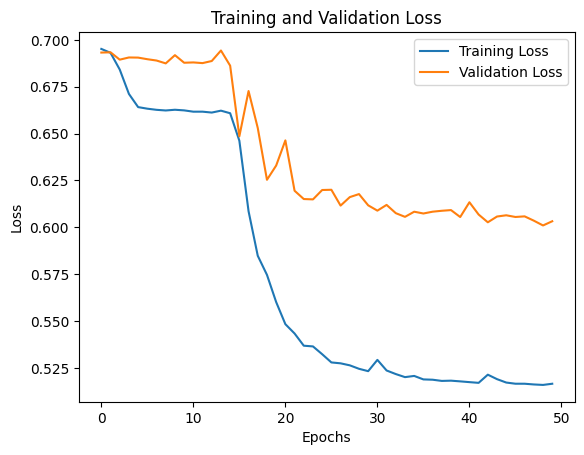

In [19]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

It is seen that the training loss decreases rapidly as the epochs progress and the model learns the training data better and better. The validation loss also decreases significantly at the beginning, but after a certain point it becomes more horizontal, indicating that the model adapts to the validation data but the improvement slows down in the following epochs.

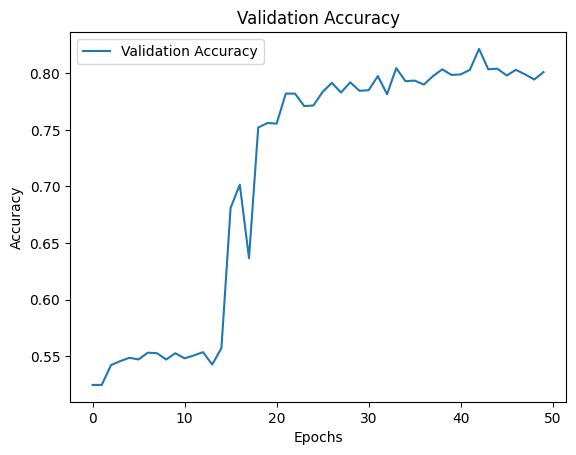

In [20]:
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')
plt.show()

It is noticed that the validation accuracy starts from a low level at the beginning and gradually increases. Although there are small fluctuations after reaching approximately 80 percent, it generally remains at this high level, indicating that the generalization performance of the model has stabilized at a reasonable point.

### 7. Testing and Analysis (15 points)

In [21]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)

        preds = (outputs > 0.5).long()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Test Set Performance:")
print(f"Accuracy: {accuracy_score(all_labels, all_preds) * 100:.2f}%")
print(f"Precision: {precision_score(all_labels, all_preds) * 100:.2f}%")
print(f"Recall: {recall_score(all_labels, all_preds) * 100:.2f}%")
print(f"F1 Score: {f1_score(all_labels, all_preds) * 100:.2f}%")

Test Set Performance:
Accuracy: 79.80%
Precision: 80.58%
Recall: 80.27%
F1 Score: 80.43%


The performance of the model on the test dataset shows that it exhibits consistent success in terms of both accuracy and F1 score. In particular, the closeness of the precision and recall values shows that the model can manage false positive and false negative predictions in a balanced manner and distinguish positive/negative classes with similar success levels. This consistency indicates a good classification performance in general.

During the training phase, the loss value is observed to drop rapidly, and there is a noticeable improvement in validation performance initially. Achieving around 80% validation accuracy indicates that the model's overall performance is at a satisfactory level. Similarly, obtaining approximately 80% accuracy, precision, recall, and F1 scores on the test set confirms that this success has largely translated into generalization capability. The close values of precision and recall suggest that the model has balanced classification, managing both false positives and false negatives with similar accuracy.

Fluctuations in validation metrics during training may be influenced by factors such as the learning rate adjustment or the characteristics of the dataset. Enhancing the model's performance is possible by using more data or improving the quality of the existing data. Additionally, increasing the use of regularization techniques like dropout or weight decay can help reduce the risk of overfitting and ensure stability.

In [22]:
# Step 1: Load the test data
test_file_path = '/content/drive/My Drive/subset1000_IMDB_Dataset.csv'  # Adjust this to the test dataset file path
test_data = pd.read_csv(test_file_path)

# Predefine tokenizer and other preprocessing utilities (reuse from training)

# Step 2: Preprocess the test data, apply the steps used during training (change according to your implementation)
test_data["cleaned_tokens"] = test_data["review"].apply(preprocess_text)
test_data["indices"] = test_data["cleaned_tokens"].apply(lambda tokens: [tokens_code.get(token, 0) for token in tokens])
padded_test = test_data["indices"].apply(lambda x: pad_sequence(x, int(max_lenght))) # Replace with the maximum sequence length used during training

# Convert to PyTorch tensor
test_tensor = torch.tensor(padded_test, dtype=torch.long)

# Step 3: Load the best-performing model
model.eval()

# Step 4: Predict sentiment for the test reviews
batch_size = 32
kaggle_loader = DataLoader(test_tensor, batch_size=batch_size, shuffle=False)

predictions = []
with torch.no_grad():
    for batch in kaggle_loader:
        batch = batch.to(device)
        outputs = model(batch)
        preds = torch.round(outputs).squeeze().tolist()
        predictions.extend(preds)

# Step 5: Map predicted class labels to corresponding class names
class_labels = {0: 'negative', 1: 'positive'}

# Step 6: Save predictions to CSV file
df = pd.DataFrame({'ID': range(1, len(predictions) + 1), 'sentiment': [class_labels[p] for p in predictions]})
df.to_csv('predictions.csv', index=False)

#### Kaggle Result: %92.2 (username = RdncRc)